In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import sklearn
import tensorflow as tf
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [21]:
cfg = dict(
    data_dir_in = os.path.join('..', 'data'),
    data = 'Sverepec_spolu.zip',
    data_sampling = True,
    topn_classes = 4,
    classes = [],
    class_column = 'DRUH_DR',
    common_class_name = 'OTHER',
    train_val_frac = 0.7
)

if cfg['classes'] is not None and len(cfg['classes']) > 0:
    cfg['dataset_label'] = '-'.join(sorted(cfg['classes']))
else:
    cfg['dataset_label'] = 'top%d' % cfg['topn_classes'] 

cfg['data_dir_out'] = os.path.join(
    cfg['data_dir_in'],
    'Sverepec_spolu_preprocessed_%s' % cfg['dataset_label']
)

display(JSON(cfg))

<IPython.core.display.JSON object>

In [22]:
if not os.path.isdir(cfg['data_dir_out']):
    if not os.path.exists(cfg['data_dir_out']):
        os.mkdir(cfg['data_dir_out'])

In [23]:
def sample_data(
    df: pd.DataFrame,
    topn_classes: int = -1,
    classes: list = [],
    dedup: bool = True,
    class_column: str = cfg['class_column'],
    common_class_name: str = cfg['common_class_name'],
    **args
) -> pd.DataFrame:

    df = df.copy(deep=True)
    
    if dedup:
        # remove duplicates
        mask = df.duplicated(keep='first')
        df = df[~mask]
    
    # classes counts
    df_hist = df[[class_column]].groupby(class_column)[class_column].count().sort_values(ascending=False)
    logger.debug('df_hist:\n%s' % str(df_hist))

    # select all classes by default
    selected_classes = df_hist.index.values
    if classes is not None and len(classes) > 0:
        # select specific classes
        selected_classes = classes
    elif topn_classes > 0:
        # select the most frequent classes
        selected_classes = df_hist.head(topn_classes).index.values
    logger.debug('selected_classes: %s' % str(selected_classes))

    # set the rest of the classes to common class
    mask = df[class_column].isin(selected_classes)
    df.loc[~mask,[class_column]] = common_class_name

    # the number of samples for the least frequent class of the most frequent classes
    min_count = df[[class_column]].groupby(class_column)[class_column].count().min()
    logger.debug('min_count: %d' % min_count)

    # sample data per class
    df_sampled = pd.DataFrame()
    for class_name in tqdm(df[class_column].unique(), desc='sampling classes'):
        df_class = df[df[class_column].str.match(class_name)].sample(n=min_count, axis=0)
        df_sampled = pd.concat([df_sampled, df_class])

    return df_sampled

def split_df(df, frac=0.7, random_state=0):
    df_train = df.sample(frac=frac, axis=0, random_state=random_state)
    df_val = df[~df.index.isin(df_train.index)]
    return df_train, df_val

def plot_band_characteristics(df, filename=None, fileformat='pdf', cmap=matplotlib.cm.get_cmap('Spectral')):
    cols = df.columns[df.columns.to_series().str.match(r'^b\d+.*')]
    n_cols = cols.shape[0]
    num_classes = df.DRUH_DR.unique().shape[0]
    col_wrap = num_classes
    if num_classes >= 4:
        col_wrap = int(np.ceil(np.sqrt(num_classes)))
    g = sns.FacetGrid(df, col='DRUH_DR', col_wrap=col_wrap, sharex=False)
    # plot only features starting with 'b0, b1, ..., b9'
    for col in enumerate(cols):
        if col[0] >= n_cols:
            break
        w = (1.0 / n_cols) * 0.0
        c = col[0]*((1.0-w)/n_cols)+0.5*w
        rgba = cmap(c)
        gg = g.map(sns.kdeplot, col[1], label=col[1], warn_singular=False, color=rgba)
        gg.set_axis_labels(x_var='')
    # g.add_legend()
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()
    
def plot_hist(df: pd.DataFrame, col_name='DRUH_DR', stat='count', title=None, filename=None, fileformat='pdf'):
    g = sns.histplot(df[col_name], stat=stat)
    g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    if title != None:
        plt.title(title)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()
    
def plot_wavelengths(df, title=None, filename=None, fileformat='pdf', normalize=False):
    df_wavelengths = df.groupby(cfg['class_column']).mean(numeric_only=True)
    df_wavelengths = df_wavelengths.sort_values(by=cfg['class_column'], key=lambda col: col.str.lower())
    if normalize:
        scaler = sklearn.preprocessing.MinMaxScaler()
        df_wavelengths[df_wavelengths.columns] = scaler.fit_transform(df_wavelengths.T.values).T
    g = sns.lineplot(df_wavelengths.T, dashes=False, lw=1)
    g.set(xticklabels=[])
    plt.ylabel('mean reflectance')
    plt.xlabel('measured points')
    if title is not None:
        if normalize:
            title = '%s\nnormalized' % title
        plt.title(title)
    if filename is not None:
        if normalize:
            filename = re.sub(r'(\.[^.]+$)', r'-normalized\1', filename)
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()
    
def plot_wavelengths2(df, title=None, filename=None, fileformat='pdf', **args):
    df = df.melt(id_vars=cfg['class_column'])
    df = df.rename(columns={'variable': 'band', 'value': 'reflectance'})
    g = sns.lineplot(df, x='band', y='reflectance', hue=cfg['class_column'], dashes=False, lw=1, **args)
    g.set(xticklabels=[])
    if title is not None:
        plt.title(title)
    if filename is not None:
        plt.savefig(os.path.join(cfg['data_dir_out'], filename), format=fileformat)
    plt.show()

## Load

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10,DRUH_DR
0,0.002312,0.002194,0.002344,0.002613,0.002497,0.002717,0.002706,0.002898,0.002586,0.003052,...,0.046049,0.043585,0.043107,0.045929,0.051554,0.052172,0.054623,0.054570,0.054656,CR
1,0.002277,0.002337,0.002361,0.002488,0.002334,0.002713,0.002796,0.002779,0.002748,0.003034,...,0.042515,0.040856,0.039885,0.043333,0.047781,0.048725,0.047153,0.050167,0.052182,CR
2,0.002243,0.002479,0.002402,0.002322,0.002627,0.002943,0.002809,0.002854,0.002725,0.003096,...,0.044127,0.042798,0.042160,0.042548,0.048506,0.049747,0.050620,0.051325,0.054525,CR
3,0.001883,0.002045,0.002057,0.001970,0.002191,0.002052,0.002102,0.001991,0.001920,0.002308,...,0.035453,0.032728,0.033034,0.034035,0.037514,0.040421,0.040852,0.040839,0.042109,CR
4,0.002193,0.001915,0.002164,0.002090,0.002031,0.002108,0.002084,0.002123,0.001950,0.002291,...,0.026016,0.025324,0.024879,0.026462,0.029662,0.030414,0.031456,0.031279,0.032800,CR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33715,0.002469,0.002863,0.003135,0.003027,0.003056,0.003230,0.003328,0.003523,0.003396,0.003746,...,0.029615,0.028368,0.026700,0.027315,0.031556,0.033276,0.032708,0.033844,0.033287,BR
33716,0.001235,0.000966,0.000953,0.001050,0.000891,0.001143,0.000930,0.001075,0.000944,0.001074,...,0.006762,0.007508,0.006300,0.007368,0.007559,0.008111,0.009299,0.008149,0.008633,BR
33717,0.001709,0.001565,0.001225,0.001534,0.001722,0.002060,0.001738,0.001615,0.001751,0.002011,...,0.026855,0.025384,0.025439,0.025496,0.027390,0.029442,0.033317,0.032171,0.032443,BR
33718,0.001823,0.001716,0.001534,0.001772,0.001997,0.002358,0.002048,0.001988,0.001989,0.002377,...,0.029279,0.027654,0.027549,0.027910,0.030475,0.032133,0.035963,0.035193,0.035305,BR


,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b177_12_10,b178_12_10,b179_12_10,b180_12_10,b181_12_10,b182_12_10,b183_12_10,b184_12_10,b185_12_10,b186_12_10
count,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,...,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000,33720.000000
mean,0.002247,0.002304,0.002430,0.002565,0.002615,0.002691,0.002687,0.002638,0.002487,0.002943,...,0.024226,0.029662,0.028207,0.027531,0.029403,0.031902,0.033641,0.034560,0.035118,0.035639
std,0.000882,0.000927,0.000999,0.001066,0.001103,0.001149,0.001161,0.001158,0.001098,0.001331,...,0.014980,0.018450,0.017572,0.017085,0.018232,0.019761,0.020832,0.021402,0.021732,0.022028
min,0.000369,0.000332,0.000345,0.000441,0.000444,0.000410,0.000456,0.000441,0.000372,0.000461,...,0.000646,0.000580,0.000697,0.000635,0.000652,0.000638,0.000869,0.000687,0.001013,0.000771
25%,0.001588,0.001611,0.001675,0.001761,0.001775,0.001806,0.001789,0.001735,0.001632,0.001898,...,0.011574,0.014084,0.013299,0.013060,0.013952,0.015179,0.016041,0.016421,0.016770,0.016946
50%,0.002207,0.002261,0.002381,0.002520,0.002568,0.002650,0.002657,0.002603,0.002462,0.002909,...,0.022414,0.027441,0.026038,0.025482,0.027207,0.029539,0.031093,0.031970,0.032546,0.033004
75%,0.002824,0.002898,0.003079,0.003261,0.003335,0.003446,0.003457,0.003407,0.003230,0.003837,...,0.036040,0.044239,0.042118,0.041040,0.043859,0.047575,0.050114,0.051479,0.052331,0.053096
max,0.005978,0.006260,0.006729,0.007038,0.007524,0.007449,0.007360,0.007368,0.006909,0.008184,...,0.066931,0.082097,0.078523,0.076033,0.080653,0.085611,0.091917,0.093709,0.094180,0.095604


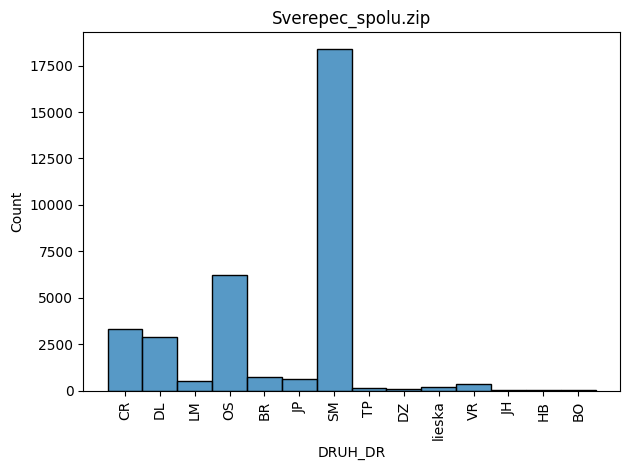

In [24]:
filename = os.path.join(cfg['data_dir_in'], cfg['data'])
df = pd.read_csv(filename)

class_mapping = {
    'ÄŤremcha': 'TP'
}

df = df.replace({cfg['class_column']: class_mapping})

display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())
display(HTML('<br/>'))
plot_hist(df, stat='count', title='%s' % cfg['data'], filename='hist_%s.pdf' % cfg['data'], fileformat='pdf')

## Data sampling

2023-04-07 17:04:42,491 | hysped | DEBUG : df_hist:
DRUH_DR
SM        18368
OS         6232
CR         3287
DL         2916
BR          727
JP          641
LM          545
VR          357
lieska      223
TP          154
DZ          125
JH           54
HB           38
BO           26
Name: DRUH_DR, dtype: int64
2023-04-07 17:04:42,492 | hysped | DEBUG : selected_classes: ['SM']
2023-04-07 17:04:42,508 | hysped | DEBUG : min_count: 15325


sampling classes:   0%|          | 0/2 [00:00<?, ?it/s]

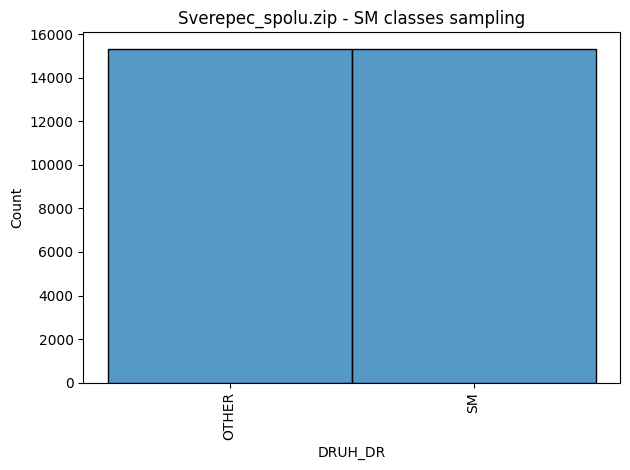

In [6]:
df_sampled = None
dataset_name = ''
if cfg['data_sampling']:
    df_sampled = sample_data(df, **cfg)

if df_sampled is not None:
    plot_hist(df_sampled, title='%s - %s classes sampling' % (cfg['data'], cfg['dataset_label']), filename='hist_%s-%s.pdf' % (cfg['data'], cfg['dataset_label']), fileformat='pdf')
    # plot_band_characteristics(df_sampled)
    df.describe() - df_sampled.describe()

## split df

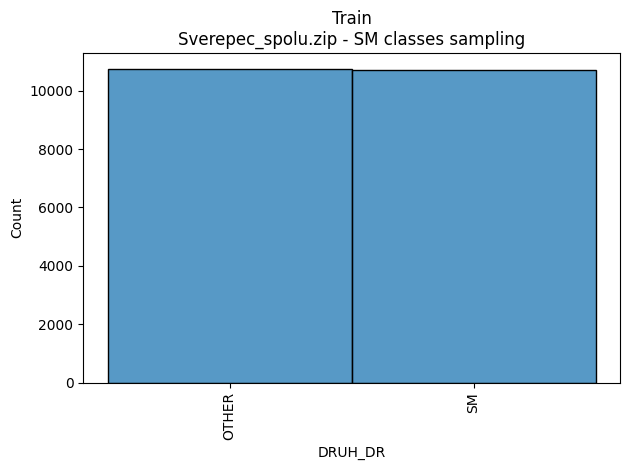

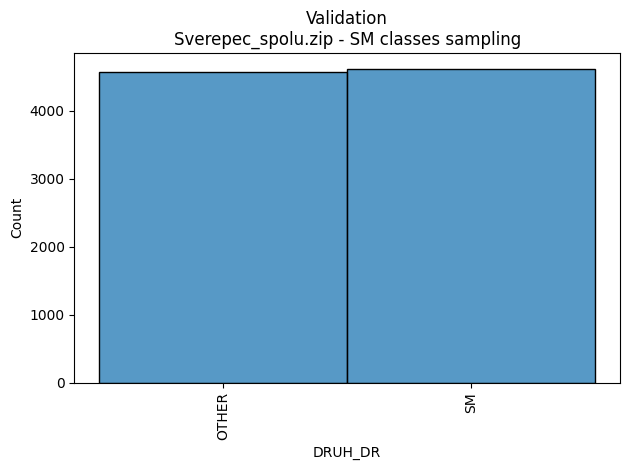

In [7]:
df_train, df_val = split_df(
    df_sampled if df_sampled is not None else df,
    frac=cfg['train_val_frac']
)

plot_hist(df_train, title='Train\n%s - %s classes sampling' % (cfg['data'], cfg['dataset_label']), filename='hist_%s-%s-train-%.1f.pdf' % (cfg['data'], cfg['dataset_label'], cfg['train_val_frac']), fileformat='pdf')
plot_hist(df_val, title='Validation\n%s - %s classes sampling' % (cfg['data'], cfg['dataset_label']), filename='hist_%s-%s-validation-%.1f.pdf' % (cfg['data'], cfg['dataset_label'], 1.0 - cfg['train_val_frac']), fileformat='pdf')

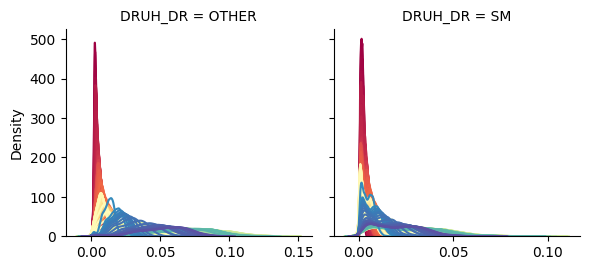

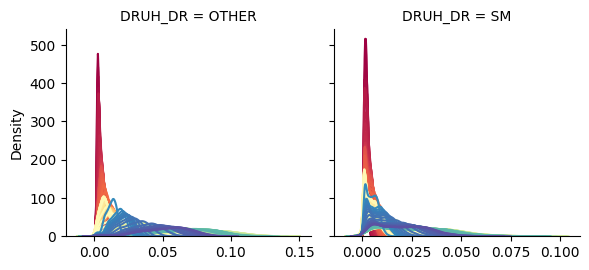

In [8]:
plot_band_characteristics(df_train, filename='density_%s-%s-train-%.1f.pdf' % (cfg['data'], cfg['dataset_label'], cfg['train_val_frac']))
plot_band_characteristics(df_val, filename='density_%s-%s-validation-%.1f.pdf' % (cfg['data'], cfg['dataset_label'], 1.0 - cfg['train_val_frac']))

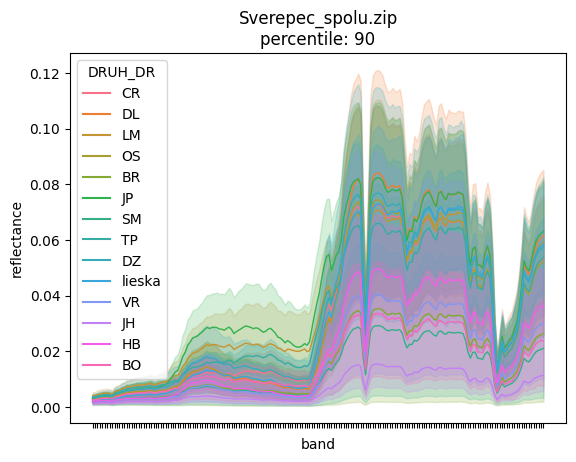

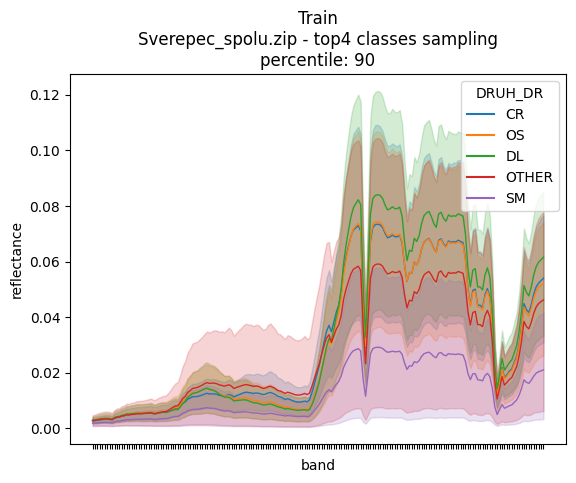

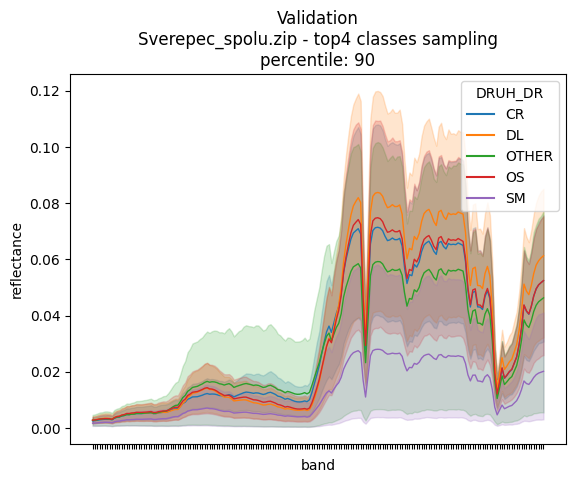

In [26]:
errorbar = ('pi', 90)
# n_boot = 2000

plot_wavelengths2(
    df,
    title='%s\npercentile: %d' % (cfg['data'], errorbar[1]),
    filename='bands_%s-pi%d.pdf' % (cfg['data'], errorbar[1]),
    errorbar=errorbar,
    # n_boot=n_boot
)
plot_wavelengths2(
    df_train,
    title='Train\n%s - %s classes sampling\npercentile: %d' % (cfg['data'], cfg['dataset_label'], errorbar[1]),
    filename='bands_%s-%s-train-%.1f-pi%d.pdf' % (cfg['data'], cfg['dataset_label'], cfg['train_val_frac'], errorbar[1]),
    errorbar=errorbar,
    # n_boot=n_boot
)
plot_wavelengths2(
    df_val,
    title='Validation\n%s - %s classes sampling\npercentile: %d' % (cfg['data'], cfg['dataset_label'], errorbar[1]),
    filename='bands_%s-%s-validation-%.1f-pi%d.pdf' % (cfg['data'], cfg['dataset_label'], 1.0 - cfg['train_val_frac'], errorbar[1]),
    errorbar=errorbar,
    # n_boot=n_boot
)

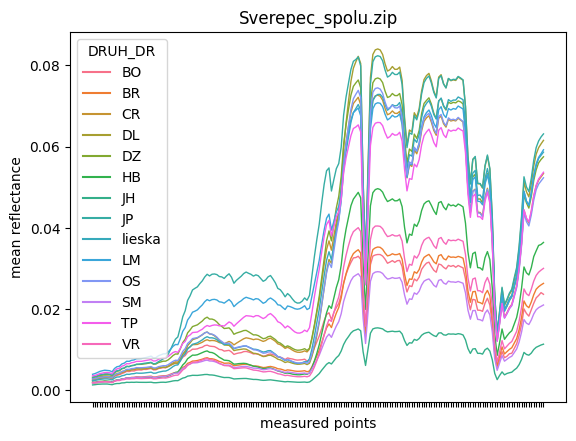

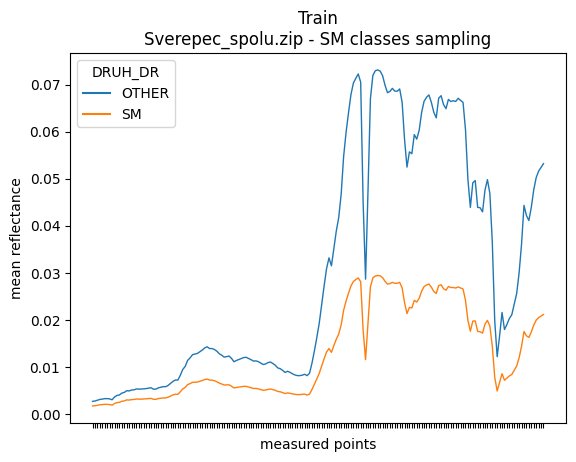

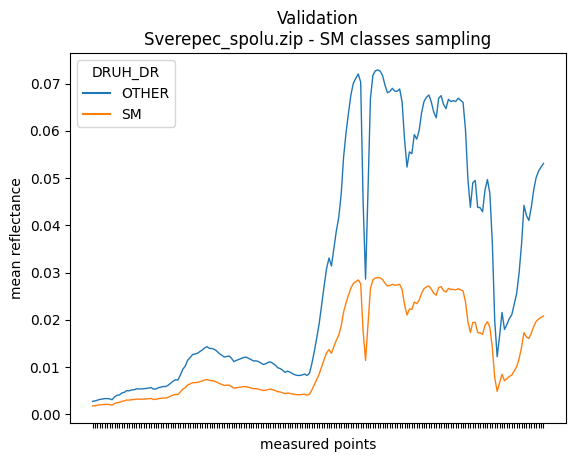

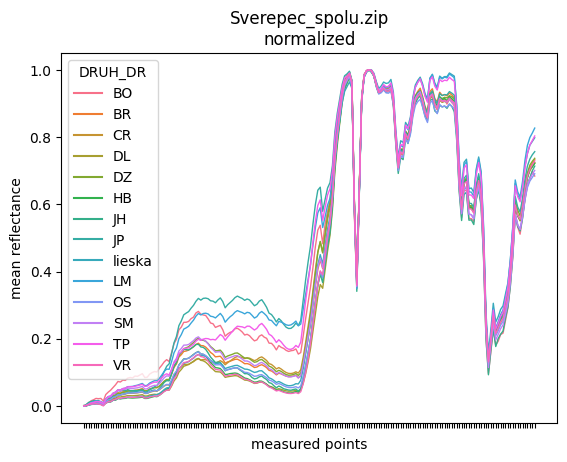

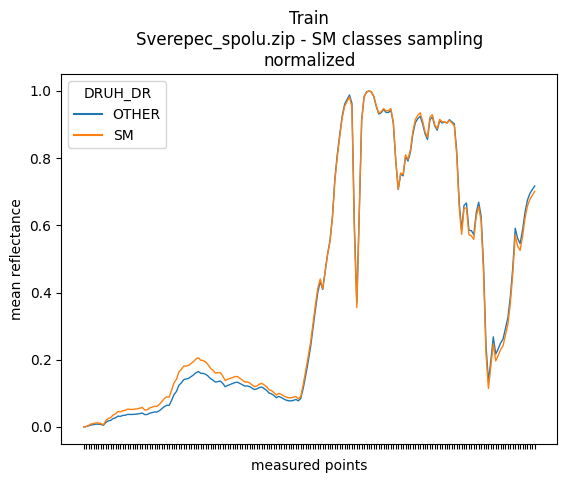

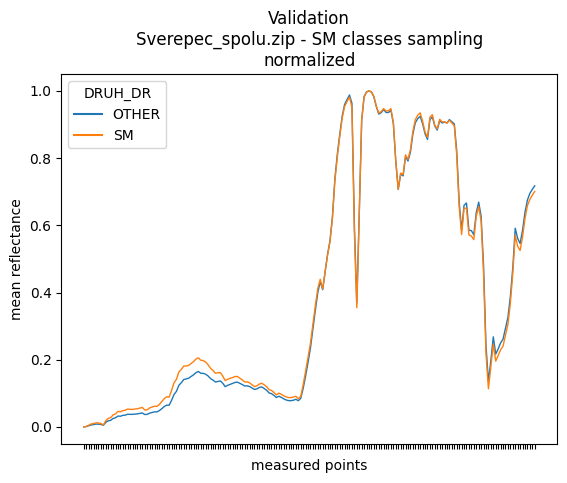

In [15]:
for normalize in [False, True]:
    plot_wavelengths(
        df,
        title='%s' % cfg['data'],
        filename='bands_%s.pdf' % cfg['data'],
        normalize=normalize
    )
    plot_wavelengths(
        df_train,
        title='Train\n%s - %s classes sampling' % (cfg['data'], cfg['dataset_label']),
        filename='bands_%s-%s-train-%.1f.pdf' % (cfg['data'], cfg['dataset_label'], cfg['train_val_frac']),
        normalize=normalize
    )
    plot_wavelengths(
        df_val,
        title='Validation\n%s - %s classes sampling' % (cfg['data'], cfg['dataset_label']),
        filename='bands_%s-%s-validation-%.1f.pdf' % (cfg['data'], cfg['dataset_label'], 1.0 - cfg['train_val_frac']),
        normalize=normalize
    )

## make X,Y for train and validation

In [10]:
#
# train
#
X_train = df_train[df_train.columns[:-1]]
Y_train = df_train[[df_train.columns[-1]]]

num_classes = (df_sampled.DRUH_DR if df_sampled is not None else df.DRUH_DR).unique().shape[0]

label_encoder = LabelEncoder()
label_encoder.fit(
    df_sampled.DRUH_DR if df_sampled is not None else df.DRUH_DR
)

# Y_train = to_categorical(
#     label_encoder.transform(Y_train[:,0]),
#     num_classes=num_classes
# )

#
# validation
#
X_val = df_val[df_val.columns[:-1]]
Y_val = df_val[[df_val.columns[-1]]]
# Y_val = to_categorical(
#     label_encoder.transform(Y_val[:,0]),
#     num_classes=num_classes
# )

# save encoder
encoder_filename = os.path.join(cfg['data_dir_out'], 'encoder-%s.npy' % cfg['class_column'])
logger.debug('saving encoder: %s' % encoder_filename)
np.save(encoder_filename, label_encoder.classes_)
        
data = {
    'X_train': X_train,
    'Y_train': Y_train,
    'X_val': X_val,
    'Y_val': Y_val
}

for name, data in data.items():
    print('%s: %s' % (name, data.shape))
    filename = os.path.join(
        cfg['data_dir_out'],
        '%s.parquet' % name
    )
    data.to_parquet(
        filename,
        engine='fastparquet',
        compression='gzip'
    ) 

2023-04-07 17:06:31,581 | hysped | DEBUG : saving encoder: ../data/Sverepec_spolu_preprocessed_SM/encoder-DRUH_DR.npy
X_train: (21455, 186)
Y_train: (21455, 1)
X_val: (9195, 186)
Y_val: (9195, 1)
